In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import statistics as stat
from scipy import stats
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gc
from torchvision import transforms 
from torchvision import models
import pickle

/home/s/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
with open('lbs.pkl', 'rb') as f:
    lbs = pickle.load(f)

In [3]:
img_files = sorted(os.listdir('test_images/'))

In [4]:
df = pd.DataFrame(columns=['img', 'path'])
df['img'] = img_files
df['path'] = 'test_images/'+df['img']

In [5]:
tmp = [i.split('*') for i in lbs.split('-')]
wg = tmp[0]
wc = tmp[1]
wp = tmp[2]
ws = tmp[3]

In [6]:
class TestData(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __getitem__(self, index):
        image =Image.open(self.df.iloc[index]['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return self.df.shape[0]

In [7]:
%%time
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_data = TestData( df, transform)
test_dl = DataLoader(train_data, batch_size=16, shuffle=True)

CPU times: user 332 µs, sys: 38 µs, total: 370 µs
Wall time: 376 µs


In [8]:
class ShuffleNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        shufflenet = models.shufflenet_v2_x1_0()
        modules = list(shufflenet.children())[:-1]
        self.features = nn.Sequential(*modules)
        self.GENDER = nn.Linear(4096, 5)
        self.COLOR = nn.Linear(4096, 47)
        self.TYPE = nn.Linear(4096, 142)
        self.SEASON = nn.Linear(4096, 4)

    def forward(self, x):
        
        x = self.features(x)
        x = x.view(x.size(0), -1)
        g = self.GENDER(x)
        c = self.COLOR(x)
        p = self.TYPE(x)
        s = self.SEASON(x)
        return g, c, p, s

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [56]:
net = nn.DataParallel(ShuffleNet()).to(device)
net.load_state_dict(torch.load('ShuflleV2.pth', map_location='cpu'))

<All keys matched successfully>

In [57]:
def hyt(list1, list2):
    u = []
    for j in list2:
        j = torch.softmax(j, dim=0).tolist()
        index = j.index(max(j))
        u.append(list1[index])
        
    return u

In [58]:
gl = []
cl = []
pl = []
sl = []
net.eval()
for x in test_dl:
    with torch.no_grad():
        G, C, P, S = net(x)
        gl+=hyt(wg, G)
        cl+=hyt(wc, C)
        pl+=hyt(wp, P)
        sl+=hyt(ws, S)

In [68]:
df['gender'] = gl
df['color'] = cl
df['product_type'] = pl
df['season'] = sl

In [69]:
df

img  \
0   Screenshot from 2023-04-07 07-54-08.png   
1   Screenshot from 2023-04-07 07-54-34.png   
2   Screenshot from 2023-04-07 07-55-01.png   
3   Screenshot from 2023-04-07 07-55-28.png   
4   Screenshot from 2023-04-07 07-56-00.png   
5   Screenshot from 2023-04-07 07-56-46.png   
6   Screenshot from 2023-04-07 07-58-33.png   
7   Screenshot from 2023-04-07 07-59-33.png   
8   Screenshot from 2023-04-07 08-01-44.png   
9   Screenshot from 2023-04-07 08-02-15.png   
10  Screenshot from 2023-04-07 08-03-14.png   
11  Screenshot from 2023-04-07 08-04-14.png   

                                                 path  gender     color  \
0   test_images/Screenshot from 2023-04-07 07-54-0...     Men       Red   
1   test_images/Screenshot from 2023-04-07 07-54-3...     Men  Charcoal   
2   test_images/Screenshot from 2023-04-07 07-55-0...     Men     Black   
3   test_images/Screenshot from 2023-04-07 07-55-2...     Men    Orange   
4   test_images/Screenshot from 2023-04-07 07-56-0...   Women     Multi   
5   test_images/Screenshot from 2023-04-07 07-56-4...   Women      Grey   
6   test_images/Screenshot from 2023-04-07 07-58-3...     Men      Grey   
7   test_images/Screenshot from 2023-04-07 07-59-3...   Women     Beige   
8   test_images/Screenshot from 2023-04-07 08-01-4...  Unisex     Green   
9   test_images/Screenshot from 2023-04-07 08-02-1...   Women      Pink   
10  test_images/Screenshot from 2023-04-07 08-03-1...  Unisex     Black   
11  test_images/Screenshot from 2023-04-07 08-04-1...  Unisex      Blue   

             product_type  season  
0                 Jackets    Fall  
1             Sweatshirts    Fall  
2            Lounge Pants  Winter  
3      Fragrance Gift Set  Spring  
4          Lounge Tshirts  Winter  
5                  Briefs  Winter  
6             Sweatshirts    Fall  
7   Perfume and Body Mist  Spring  
8            Lounge Pants  Summer  
9                  Shirts    Fall  
10           Casual Shoes    Fall  
11  Perfume and Body Mist  Spring

In [15]:
img = plt.imread('test_images/Screenshot from 2023-04-07 07-54-34.png')

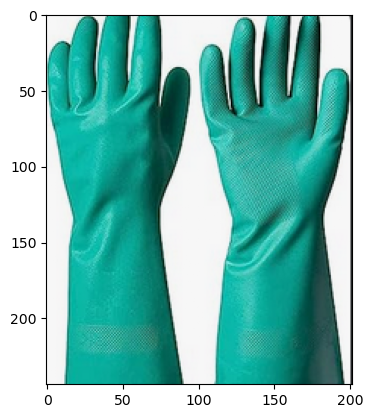

In [16]:
plt.imshow(img)